In [2]:
import optuna
from tqdm import tqdm
import logging
import sys
import torch
import os
from datetime import datetime
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torch.utils.data
#from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image
import zookeeper as zk  # convool_size & mappy
import pickle  # for artifact, maybe not useful

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


import shutil
    
data = pd.read_csv('../data/og/training_solutions_rev1.csv')
test = data.sample(frac=.1)
train = data.drop(test.index)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.to_csv('../data/training/training_solutions_rev1.csv', index_label=False)
test.to_csv('../data/test/test_solutions_rev1.csv', index_label=False)

for image in (train.GalaxyID.astype('string') + '.jpg').values:
    shutil.move(os.path.join('../data/og/', image), os.path.join('../data/training/', image))

for image in (test.GalaxyID.astype('string') + '.jpg').values:
    shutil.move(os.path.join('../data/og/', image), os.path.join('../data/test/', image))

train.head()


pd.read_csv('../data/test/test_solutions_rev1.csv').shape[0] + pd.read_csv('../data/training/training_solutions_rev1.csv').shape[0]

### Define Dataset function

In [56]:
class GalaxyJungle(Dataset):
    
    #the init function initializes the directory containing the image,
    #the annotations file,
    #and both transforms
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, is_rgb=False):
        self.rgb = is_rgb
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    #returns number of samples in the dataset
    def __len__(self):
        return (self.img_labels).shape[0]

    #loads a sample from the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        #retrieves the image
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        #retrieves corresponding label
        label = self.img_labels.iloc[idx, 1:]
        #if possible, transform the image and the label into a tensor.
        if self.transform:
            image = self.transform(image)#.type(torch.float16)
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, self.img_labels.iloc[idx, 0]
    

transfs = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
    transforms.RandomRotation(180)
    ])

## NEURAL NETWORK

al = [0, 0, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2]
inp = 128
for i in al:
    if i == 0: inp = zk.convool_size(inp, 3, 1, 'same')
    elif i == 2: inp = zk.convool_size(inp, 2, 2)
    else: inp = zk.convool_size(inp, 3, 1)
inp

In [6]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, is_rgb=False):
        super().__init__()
        
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation

        
        ## convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            

            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),
 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),            

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()



    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        return x



    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        # Init convolutional parameters
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)
        

        # Init linear parameters
        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        


    def log_the_loss(self, item,epoch=False): # per avere una history della loss???
        verbose=False
        train = self.__getstate__()['training']
        if verbose: print(train)
        if epoch and train:
            self.loss_dict['epoch'].append(item) ### get state of the model so you can ditch the validation parameter
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item

## TRAINING + VALIDATION

In [58]:
def one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False):
    running_loss = 0
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        inputs,labels, _ = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step() # fa update del parameter
        RMSEloss = np.sqrt(loss.item())
        running_loss += RMSEloss
        if verbose and i%10 ==0: print(f'Batch {i+1}/{len(train_loader)} - Loss: {RMSEloss:.3f}')

        model.log_the_loss(RMSEloss, epoch=False)
    epochmean_loss = running_loss / len(train_loader)
    print(f'\nLoss: {epochmean_loss}')
    model.log_the_loss(epochmean_loss, epoch=True)
    last_loss = RMSEloss
    print(f"Last loss: {last_loss}")
    return epochmean_loss



def one_epoch_eval(model, test_loader, loss_function, verbose=False):
    model.eval()
    running_validation_loss = 0.
   
    with torch.no_grad(): # deactivates gradient evaluation
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, _ = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = model(inputs)#, activation=F.relu)
            loss = loss_function(outputs ,labels)
            RMSEloss = np.sqrt(loss.item())
            running_validation_loss +=RMSEloss
            model.log_the_loss(RMSEloss,epoch=False)
    mean_vloss=model.log_the_loss(running_validation_loss / len(test_loader),epoch=True)
    print(f"Validation Loss: {mean_vloss}\n---")
    return mean_vloss

## OPTUNA


In [59]:
DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs)
training, test = random_split(DS, [.8, .2])

artifact_store = optuna.artifacts.FileSystemArtifactStore(base_path='./artifacts')

def objective(trial:optuna.Trial):
    epochs = 50
    loss_function = nn.MSELoss()
    train_loader = DataLoader(training, batch_size=32, shuffle=True, num_workers=os.cpu_count())
    test_loader = DataLoader(test, batch_size=32, shuffle=False, num_workers=os.cpu_count())    
    
    # Trial choices
    activation = trial.suggest_categorical("activation", ['ReLU', 'LeakyReLU'])
    optimizer = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'AdamW', 'RMSprop', 'Adagrad', 'NAdam']) #AdamW è suggerito per CNN.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True) #log true cerca i valori in scala logaritmica
    momentum = trial.suggest_float("momentum", 0.3, 0.9, step=0.1) #per SGD
    initialization = trial.suggest_categorical('init weight', [True, False])
    
    # Training phase
    activation = getattr(nn, activation)
    model = GalaxyNet(activation, initialization).to(device)
    if optimizer in ('SGD', "RMSprop"): optimizer = getattr(optim, optimizer)(model.parameters(), lr=learning_rate, momentum = momentum)
    else: optimizer = getattr(optim, optimizer)(model.parameters(), lr=learning_rate)
    
    
    for epoch in range(epochs):
        print(f'Training epoch {epoch}')
        one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False)

        print(f'Validation epoch {epoch}')
        epoch_last_val_loss = one_epoch_eval(model, test_loader, loss_function, verbose=False)
        trial.report(epoch_last_val_loss, epoch)


        if trial.should_prune(): raise optuna.TrialPruned()

    with open('model.pickle', 'wb') as fout: pickle.dump(model, fout)
    art_id = optuna.artifacts.upload_artifact(artifact_store=artifact_store, file_path='model.pickle', study_or_trial=trial.study)
    trial.set_user_attr('artifact_id', art_id)

    
    return epoch_last_val_loss

In [ ]:
from optuna_dashboard import run_server
run_server('sqlite:///JAGZooNet.db')

ImportError: cannot import name 'run_server' from partially initialized module 'optuna_dashboard' (most likely due to a circular import) (/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/optuna_dashboard/__init__.py)

In [60]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "PADel"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective, n_trials=1)

[I 2025-05-25 23:46:29,618] A new study created in RDB with name: PADel


A new study created in RDB with name: PADel
A new study created in RDB with name: PADel
Convs output size: 2
Training epoch 0


1386it [00:58, 23.87it/s]


Loss: 0.1324329789321179
Last loss: 0.12762539469679385
Validation epoch 0



347it [00:13, 24.86it/s]

Validation Loss: 0.11542691591824177
---
Training epoch 1



158it [00:07, 20.87it/s]
[W 2025-05-25 23:47:50,074] Trial 0 failed with parameters: {'activation': 'ReLU', 'optimizer': 'Adam', 'learning_rate': 0.00047446153692471234, 'momentum': 0.9, 'init weight': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_24022/1031468632.py", line 28, in objective
    one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False)
  File "/tmp/ipykernel_24022/1592106897.py", line 4, in one_epoch_train
    for i, data in tqdm(enumerate(train_loader)):
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
               ^^^^^^^^
  File "/home/teobaldo/min

Trial 0 failed with parameters: {'activation': 'ReLU', 'optimizer': 'Adam', 'learning_rate': 0.00047446153692471234, 'momentum': 0.9, 'init weight': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_24022/1031468632.py", line 28, in objective
    one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False)
  File "/tmp/ipykernel_24022/1592106897.py", line 4, in one_epoch_train
    for i, data in tqdm(enumerate(train_loader)):
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
               ^^^^^^^^
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/torch

[W 2025-05-25 23:47:50,084] Trial 0 failed with value None.


Trial 0 failed with value None.
Trial 0 failed with value None.


KeyboardInterrupt: 

In [9]:
for i in os.listdir():
    print(i)

__pycache__
reader.py
.ipynb_checkpoints
JAGZooNet.db
.git
optuna.ipynb
README.md
PADel.db
jagzoo.pickle
artifacts
classes.py
mapper.ipynb
PCNet.db
scaletta.md
journal.md
model.pickle
gionet.ipynb
zookeeper.py
Readdata.ipynb
PC.pickle
runner.py
.gitignore


In [ ]:
device = 'cuda'
torch.set_printoptions(sci_mode=False)
model = pd.read_pickle('/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/artifacts/0ddf5239-9466-41c5-8aa7-7f222cf815e5')
DS = GalaxyJungle('../data/test/test_solutions_rev1.csv', '../data/test/', transfs)
train_loader = DataLoader(DS, batch_size=1, shuffle=True, num_workers=os.cpu_count())

stuff = next(iter(train_loader))
print('TRUE LABEL\n')
print(stuff[1])
model.eval()
out = model(stuff[0].to(device))
print('PREDICT\n')
print(out)

print('TRUE LABEL - PREDICT\n')
print(stuff[1].to(device) - out)
plt.imshow(stuff[0][0][0])

model = pd.read_pickle('./artifacts/fbd42892-4aa7-409e-84e3-17fafae221cc')


# print(model.loss_dict)
print('?', model.loss_dict['epoch'])

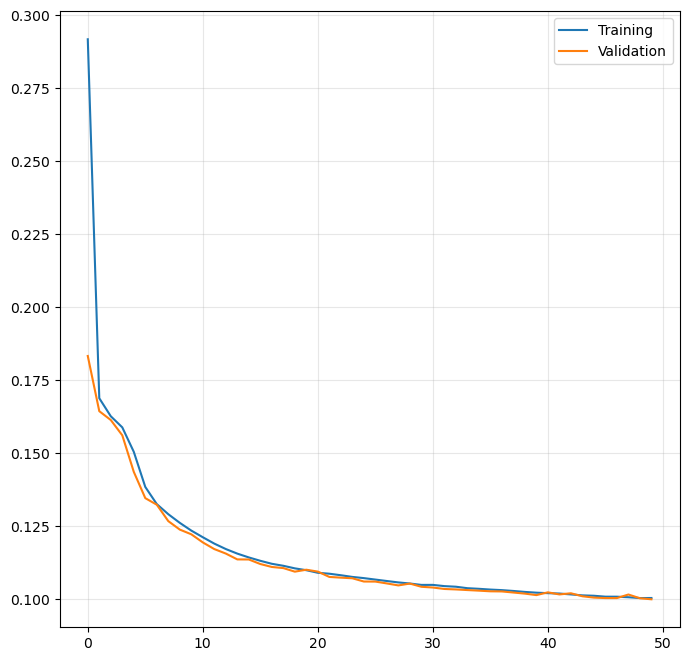

In [ ]:
lossd = pd.read_pickle('./artifacts/ec3820ea-6658-47f3-8139-94ad4a8883c5').loss_dict
lossd.keys()
fig, ax = plt.subplots(figsize=(8,8))

ax.grid(alpha=0.3)
ax.plot(range(len(lossd['epoch'])), lossd['epoch'], label='Training')
ax.plot(range(len(lossd['epoch'])), lossd['vepoch'], label='Validation')
ax.legend(loc='upper right')
plt.show()